<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/2_4_Experiments_falloff_to_GP_Feynman_diagrams_at_large_width.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Introduction

In the infinite width limit, the experimental results for the $n$-pt function $G^{(n)}$ converge to the GP, $G_{GP}^{(n)}$.

This notebook studies three single hidden layer architectures to testify the GP limit in these networks.

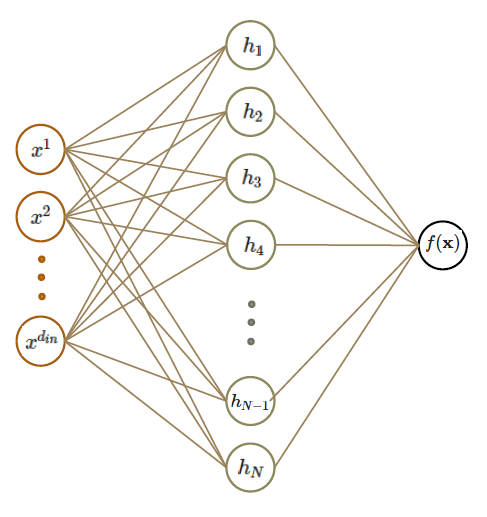

### How to measure the deviation

We compute normalized deviation $m_n$ which is obtained from the experimental measurements $G^{(n)}$ and theoretic results of $G_{GP}^{(n)}$.

$m_n(x_1, ..., x_n) = \Delta G^{(n)}(x_1, ..., x_n) / G_{GP}^{(n)}(x_1, ..., x_n) $

$\Delta G^{(n)}(x_1, ..., x_n) = G^{(n)}(x_1, ..., x_n) - G_{GP}^{(n)}(x_1, ..., x_n)$

<br>

- $G^{(n)}(x_1, ..., x_n) = \mathcal{E}[f_{\alpha}(x_1)...f_{\alpha}(x_n)]$ is measured $100 \text{(experiments)} * 10^5 \text{(networks per experiment)}$ times.

Weights and biases are drawn from Gaussian distribution with mean equals zero and std equals 1 (0 for ReLU-net).

<br>

- $G_{GP}^{(n)}(x_1, ..., x_n)$ is computed via Wick contraction.

<br>

- In our networks:  
$d_{in} = d_{out} = 1$

## Input of the networks

Define three network architectures. 

### Gauss-net layer

$$
x \rightarrow \exp (W x+b) \rightarrow \frac{\exp (W x+b)}{\sqrt{K_{\exp }(x, x)}} \rightarrow f(x)
$$

$K_{\exp }(x, x)$ is the 2-pt function of the intermediate exponential extivation layer

$$
\sigma(x)=\frac{\exp (W x+b)}{\sqrt{\exp \left[2\left(\sigma_{b}^{2}+\frac{\sigma_{W}^{2}}{d_{\text {in }}} x^{2}\right)\right]}},
$$

In [ ]:
def Gauss(inputs, input_dim, units, sigmab2=1.0, sigmaw2=1.0):
    w = np.random.normal(scale=sigmaw2, size=(input_dim, units))
    b = np.random.normal(scale=sigmab2, size=(units,))
    nomi = np.exp(np.matmul(inputs, w) + b)
    domi = np.sqrt(np.exp(2.0*sigmab2 + 2.0*sigmaw2*np.square(np.linalg.norm(inputs, axis=1, ord=2))/input_dim))
    return nomi / np.expand_dims(domi, 1)

### Gauss-net kernel

The Gauss-net kernel is translational invariant. The normalization in the denominator of the $\sigma$ is crucial for translation invariance.

\begin{align} K_{\text {Gauss }}\left(x, x^{\prime}\right)=\sigma_{b}^{2}+\sigma_{W}^{2} \exp \left[-\frac{\sigma_{W}^{2}\left|x-x^{\prime}\right|^{2}}{2 d_{\text {in }}}\right] \end{align}

In [ ]:
def K_Gauss(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    return sigmab2 + sigmaw2 * np.exp(-sigmaw2 * np.square(x - y) / (2.0*d_in))

### Erf-net layer

The activation function of the erf-net is error function.

$$
\sigma(z)=\operatorname{Erf}(z)=\frac{2}{\sqrt{\pi}} \int_{0}^{z} d t e^{-t^{2}}
$$

In [ ]:
def Erf(inputs, input_dim, units, sigmab2=1.0, sigmaw2=1.0):
    w = np.random.normal(scale=sigmaw2, size=(input_dim, units))
    b = np.random.normal(scale=sigmab2, size=(units,))
    preact = np.matmul(inputs, w) + b
    postact = erf(preact)
    return postact

### Erf-net kernel

The associated GP kernel is
$$
K_{\mathrm{Erf}}\left(x, x^{\prime}\right)=\sigma_{b}^{2}+\sigma_{W}^{2} \frac{2}{\pi} \arcsin \left[\frac{2\left(\sigma_{b}^{2}+\frac{\sigma_{W}^{2}}{d_{\text {in }}} x x^{\prime}\right)}{\sqrt{\left(1+2\left(\sigma_{b}^{2}+\frac{\sigma_{w}^{2}}{d_{\text {in }}} x^{2}\right)\right)\left(1+2\left(\sigma_{b}^{2}+\frac{\sigma_{W}^{2}}{d_{\text {in }}} x^{\prime 2}\right)\right)}}\right]
$$

In [ ]:
def K_erf(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((1.0 + 2.0*sigmab2 + 2.0*sigmaw2*xx/d_in) * (1.0 + 2.0*sigmab2 + 2.0*sigmaw2*yy/d_in))
    return sigmab2 + sigmaw2 * (2.0 / np.pi) * np.arcsin(2.0 * (sigmab2 + sigmaw2*xy/d_in) / corr) 

### ReLU-net layer

$$
\sigma(z)=\left\{\begin{array}{ll}
0 & z<0 \\
z & z \geqslant 0
\end{array} .\right.
$$

In [ ]:
def ReLU(inputs, input_dim, units, sigmab2=0.0, sigmaw2=1.0):
    w = np.random.normal(scale=sigmaw2, size=(input_dim, units))
    b = np.random.normal(scale=sigmab2, size=(units,))
    preact = np.matmul(inputs, w) + b
    postact = np.maximum(preact, 0)
    return postact

### ReLU-net kernel

The associated GP kernel is
$$
\begin{aligned}
K_{\mathrm{ReLU}}\left(x, x^{\prime}\right) &=\sigma_{b}^{2}+\sigma_{W}^{2} \frac{1}{2 \pi} \sqrt{\left(\sigma_{b}^{2}+\frac{\sigma_{W}^{2}}{d_{\mathrm{in}}} x \cdot x\right)\left(\sigma_{b}^{2}+\frac{\sigma_{W}^{2}}{d_{\text {in }}} x^{\prime} \cdot x^{\prime}\right)(\sin \theta+(\pi-\theta) \cos \theta)}, \\
\theta &=\arccos \left[\frac{\sigma_{b}^{2}+\frac{\sigma_{w}^{2}}{d_{\mathrm{in}}} x \cdot x^{\prime}}{\sqrt{\left(\sigma_{b}^{2}+\frac{\sigma_{W}^{2}}{d_{\text {in }}} x \cdot x\right)\left(\sigma_{b}^{2}+\frac{\sigma_{\mathrm{w}}^{2}}{d_{\text {in }}} x^{\prime} \cdot x^{\prime}\right)}}\right]
\end{aligned}
$$

In [ ]:
def K_ReLU(x, y, sigmab2=0.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((sigmab2 + sigmaw2*xx/d_in) * (sigmab2 + sigmaw2*yy/d_in))
    costheta = (sigmab2 + sigmaw2*xy/d_in) / corr
    theta = np.arccos(costheta)
    return sigmab2 + sigmaw2 * (1.0 / (2.0*np.pi)) * corr * (np.sin(theta) + (np.pi - theta) * costheta)

### Dense layer

$f_{\theta, N}(x) = z_1^k = \sum_{j=1}^N W_1^{jk}x_1^j + b_1^k$

In [ ]:
def Dense(inputs, input_dim, units, sigmab2=1.0, sigmaw2=1.0):
    w = np.random.normal(scale=np.sqrt(sigmaw2/N), size=(input_dim, units))
    b = np.random.normal(scale=sigmab2, size=(units,))
    return np.matmul(inputs, w) + b

### Wick contraction

The rule of Wick contraction is simple: sum over all ways of connecting the points $\{x_1, ..., x_n\}$ in pairs, and in each term draw a line between the points in the pair $(a_i, b_i)$.

$G_{GP}^{(n)}(x_1, ..., x_n) = \sum_{p\in \textrm{Wick}(x_1, ..., x_n)} K(a_1, b_1)...K(a_{n/2}, b_{n/2})$

In [ ]:
def G_gp2(X, K):
    x1, x2 = X
    return K(x1, x2)

In [ ]:
def G_gp4(X, K):
    x1, x2, x3, x4 = X
    return K(x1, x2) * K(x3, x4) + K(x1, x3) * K(x2, x4) + K(x1, x4) * K(x2, x3)

In [ ]:
def G_gp6(X, K):
    wick_pairs = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6],
                  [1, 3, 2, 6, 4, 5], [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], 
                  [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6],
                  [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    res = 0
    for x1, x2, x3, x4, x5, x6 in wick_pairs:
        res += K(X[x1-1], X[x2-1]) * K(X[x3-1], X[x4-1]) * K(X[x5-1], X[x6-1])
    return res

### Input of each network

The inputs are chosen where the finite width NGP is well approximated by local-operator correction terms to the associated log-likelihood.
 
Inputs of ReLU-net are all positive so that the kernel is always nonzero. Also, inputs of Erf-net are chosen to be positive to make the kernel positive.

In [ ]:
X_Gauss = np.array([[-0.01], [-0.006], [-0.002], [0.002], [0.006], [0.01]])
X_erf = np.array([[0.002], [0.004], [0.006], [0.008], [0.010], [0.012]])
X_ReLU = np.array([[0.2], [0.4], [0.6], [0.8], [1.0], [1.2]])

In [ ]:
# The widths are chosen to be the following
Ns = [2, 3, 4, 5, 10, 20, 50, 100, 500, 1000]

### Mount to google drive

Variables will be saved to google drive.

In [ ]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive')

Mounted at /gdrive


### Find all distinct combination of $G^{(n)}$

Permutations in correlation function $G^{(n)}$ yield same results. Thus we only consider those combinations of distinct $G^{(n)}$ values.

In [ ]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

### n-pt function

Function to compute n-pt function of experimental results.

$$G^{(n)}(x_1, ..., x_n) = \mathcal{E}[f_{\alpha}(x_1)...f_{\alpha}(x_n)]$$

Here we have discrete weights:

$$G^{(n)}\left(x_{1}, \ldots, x_{n}\right)=\frac{1}{n_{\text {nets }}} \sum_{\alpha \in \text { nets }}^{n_{\text {nets }}} f_{\alpha}\left(x_{1}\right), \ldots, f_{\alpha}\left(x_{n}\right)$$

In [ ]:
def npt(Y, X, comb):
    Y_df = pd.DataFrame(Y, columns=X.reshape(-1))
    corr_function = []
    for c in comb:
        corr_function.append(Y_df[list(c)].prod(1).mean())
    
    return np.array(corr_function) # shape = len(comb)

### Calculate $m_n$

$m_n$ is the normalized deviation.

$$m_n(x_1, ..., x_n) = \Delta G^{(n)}(x_1, ..., x_n) / G_{GP}^{(n)}(x_1, ..., x_n) $$

$$\Delta G^{(n)}(x_1, ..., x_n) = G^{(n)}(x_1, ..., x_n) - G_{GP}^{(n)}(x_1, ..., x_n)$$

In [ ]:
def mn(X, comb, dir, npt_gp):
    res = []
    files = list(pathlib.Path(dir).glob('*'))
    for file in files:
        with open(file, 'rb') as handle:
            fx_exp = pickle.load(handle)  # fx_exp.shape = 100*100000*6
        m_ns = []    # m_ns.shape = 100*len(comb)
        for Y in fx_exp: # Y.shape = 100000*6
            m_ns.append((npt(Y, X, comb) - npt_gp) / npt_gp)
        res.append(m_ns)
    # res.shape = 10*100*len(comb)
    return np.array(res)

### Plot $m_n$

$m_n$ is compared with its background fluctuation, which is the average elementwise standard deviation across 100 experiments of the tensor elements $m_n$.

In [ ]:
def plot_mn(m_n):
    std_df = pd.DataFrame(np.log10(m_n.std(1)), columns=['background']*m_n.shape[-1])
    mean_df = pd.DataFrame(np.log10(np.abs(m_n.mean(1))), columns=['signal']*m_n.shape[-1])  
    colors = ['r']*m_n.shape[-1] + ['b']*m_n.shape[-1]
    concated_df = pd.concat([std_df, mean_df], axis=1)
    concated_df.index = [np.log10(N) for N in Ns]
    ax = concated_df.plot(color=colors, legend=False)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
    plt.show() 
    return None

## Gauss-net

### Find all disinct combination of $x_i$

In [ ]:
comb2 = findsubsets(X_Gauss.reshape(-1), 2)
print(len(comb2))
comb4 = findsubsets(X_Gauss.reshape(-1), 4)
print(len(comb4))
comb6 = findsubsets(X_Gauss.reshape(-1), 6)
print(len(comb6))

21
126
462


### Calculate gaussian process 2, 4, 6-pt functions

Calculate theoretical 2, 4, 6-pt functions.

In [ ]:
pt2_gp_Gauss = []
for c in comb2:
    pt2_gp_Gauss.append(G_gp2(c, K_Gauss))

pt2_gp_Gauss = np.array(pt2_gp_Gauss)

In [ ]:
pt4_gp_Gauss = []
for c in comb4:
    pt4_gp_Gauss.append(G_gp4(c, K_Gauss))

pt4_gp_Gauss = np.array(pt4_gp_Gauss)

In [ ]:
pt6_gp_Gauss = []
for c in comb6:
    pt6_gp_Gauss.append(G_gp6(c, K_Gauss))

pt6_gp_Gauss = np.array(pt6_gp_Gauss)

### Calculate the network output

Construct Gauss-net by randomly initializing its weights and bias and save the network outputs to google drive.

In [ ]:
%%time
fx_exps = []

for N in Ns:

    print('Proceeding N =', N, '...')
    fx_exp = []
    for j in range(100):
        Y = []
        for i in range(100000):
            m = Gauss(X_Gauss, 1, N)
            y = Dense(m, N, 1) 
            Y.append(y)
        Y = np.array(Y).reshape(100000, 6)
        fx_exp.append(Y)

    fx_exp = np.array(fx_exp)
    with open('/gdrive/MyDrive/NNGP/Gauss/fx_exp_'+str(N)+'.pickle', 'wb') as handle:
        pickle.dump(fx_exp, handle)
    fx_exps.append(fx_exp)

Proceeding N = 2 ...
Proceeding N = 3 ...
Proceeding N = 4 ...
Proceeding N = 5 ...
Proceeding N = 10 ...
Proceeding N = 20 ...
Proceeding N = 50 ...
Proceeding N = 100 ...
Proceeding N = 500 ...
Proceeding N = 1000 ...
CPU times: user 3h 4min 26s, sys: 1min 19s, total: 3h 5min 45s
Wall time: 3h 5min 5s


### Calculate and save $m_n$

In [ ]:
%%time
m_n2 = mn(X_Gauss, comb2, '/gdrive/MyDrive/NNGP/Gauss/', pt2_gp_Gauss)

CPU times: user 2min 41s, sys: 9.64 s, total: 2min 51s
Wall time: 3min 24s


In [ ]:
with open('/gdrive/MyDrive/NNGP/Gauss_m_n2.pickle', 'wb') as handle:
    pickle.dump(m_n2, handle)

In [ ]:
%%time
m_n4 = mn(X_Gauss, comb4, '/gdrive/MyDrive/NNGP/Gauss/', pt4_gp_Gauss)

with open('/gdrive/MyDrive/NNGP/Gauss_m_n4.pickle', 'wb') as handle:
    pickle.dump(m_n4, handle)

CPU times: user 19min 17s, sys: 1min 24s, total: 20min 41s
Wall time: 21min 9s


In [ ]:
%%time
m_n6 = mn(X_Gauss, comb6, '/gdrive/MyDrive/NNGP/Gauss/', pt6_gp_Gauss)

with open('/gdrive/MyDrive/NNGP/Gauss_m_n6.pickle', 'wb') as handle:
    pickle.dump(m_n6, handle)

CPU times: user 1h 24min 19s, sys: 9min 28s, total: 1h 33min 48s
Wall time: 1h 34min 7s


### Load $m_n$

The results show that 2-pt deviations $\Delta G^{(2)}$ are below the background level and therefore consistent with zero for all three architectures, indicating that the kernel is an exact measure of the 2-pt correlation function even away from the GP. 

The 4-pt and 6-pt signals are linearly decreasing (on a log-log scale) with increasing width in the region above the background level, falling below the background level at higher widths. The slope of the line in the region above the background is $\simeq-1$, indicating in our experiments that
$$
\Delta G^{(n)} \propto N^{-1}
$$
for $n=4,6$, up to experimental errors, shown by the flattening of signal well below the background. This explicitly demonstrates the falloff to GP as the width increases.

In [ ]:
with open('/gdrive/MyDrive/NNGP/Gauss_m_n2.pickle', 'rb') as handle:
    m_n2 = pickle.load(handle)

with open('/gdrive/MyDrive/NNGP/Gauss_m_n4.pickle', 'rb') as handle:
    m_n4 = pickle.load(handle)

with open('/gdrive/MyDrive/NNGP/Gauss_m_n6.pickle', 'rb') as handle:
    m_n6 = pickle.load(handle)

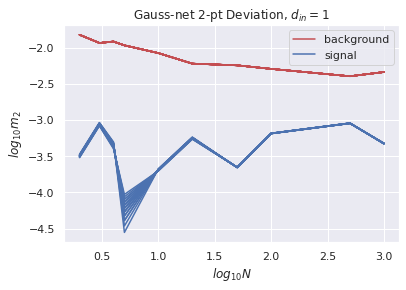

In [ ]:
std_df = pd.DataFrame(np.log10(m_n2.std(1)), columns=['background']*m_n2.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n2.mean(1))), columns=['signal']*m_n2.shape[-1])  
colors = ['r']*m_n2.shape[-1] + ['b']*m_n2.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_2$")
plt.title("Gauss-net 2-pt Deviation, $d_{in} = 1$")
plt.show() 

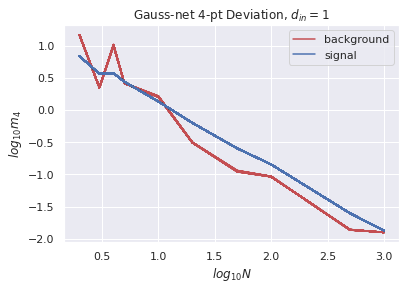

In [ ]:
std_df = pd.DataFrame(np.log10(m_n4.std(1)), columns=['background']*m_n4.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n4.mean(1))), columns=['signal']*m_n4.shape[-1])  
colors = ['r']*m_n4.shape[-1] + ['b']*m_n4.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_4$")
plt.title("Gauss-net 4-pt Deviation, $d_{in} = 1$")
plt.show() 

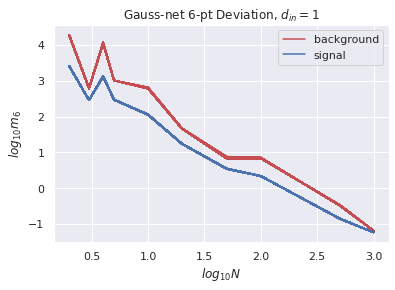

In [ ]:
std_df = pd.DataFrame(np.log10(m_n6.std(1)), columns=['background']*m_n6.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n6.mean(1))), columns=['signal']*m_n6.shape[-1])  
colors = ['r']*m_n6.shape[-1] + ['b']*m_n6.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_6$")
plt.title("Gauss-net 6-pt Deviation, $d_{in} = 1$")
plt.show() 

## ReLU-net

We carry out experiments of ReLU-net and erf-net in the same way.

### Find all disinct combination of $x_i$

In [ ]:
comb2 = findsubsets(X_ReLU.reshape(-1), 2)
print(len(comb2))
comb4 = findsubsets(X_ReLU.reshape(-1), 4)
print(len(comb4))
comb6 = findsubsets(X_ReLU.reshape(-1), 6)
print(len(comb6))

21
126
462


### Calculate gaussian process 2, 4, 6-pt functions

In [ ]:
pt2_gp_ReLU = []
for c in comb2:
    pt2_gp_ReLU.append(G_gp2(c, K_ReLU))

pt2_gp_ReLU = np.array(pt2_gp_ReLU)

In [ ]:
pt4_gp_ReLU = []
for c in comb4:
    pt4_gp_ReLU.append(G_gp4(c, K_ReLU))

pt4_gp_ReLU = np.array(pt4_gp_ReLU)

In [ ]:
pt6_gp_ReLU = []
for c in comb6:
    pt6_gp_ReLU.append(G_gp6(c, K_ReLU))

pt6_gp_ReLU = np.array(pt6_gp_ReLU)

### Calculate the network output

In [ ]:
%%time
fx_exps = []

for N in Ns:

    print('Proceeding N =', N, '...')
    fx_exp = []
    for j in range(100):
        Y = []
        for i in range(100000):
            m = ReLU(X_ReLU, 1, N)
            y = Dense(m, N, 1, sigmab2=0.0)
            Y.append(y)
        Y = np.array(Y).reshape(100000, 6)
        fx_exp.append(Y)

    fx_exp = np.array(fx_exp)
    with open('/gdrive/MyDrive/NNGP/ReLU/fx_exp_'+str(N)+'.pickle', 'wb') as handle:
        pickle.dump(fx_exp, handle)
    fx_exps.append(fx_exp)

Proceeding N = 2 ...
Proceeding N = 3 ...
Proceeding N = 4 ...
Proceeding N = 5 ...
Proceeding N = 10 ...
Proceeding N = 20 ...
Proceeding N = 50 ...
Proceeding N = 100 ...
Proceeding N = 500 ...
Proceeding N = 1000 ...


### Calculate and save $m_n$

In [ ]:
%%time
m_n2 = mn(X_ReLU, comb2, '/gdrive/MyDrive/NNGP/ReLU/', pt2_gp_ReLU)

with open('/gdrive/MyDrive/NNGP/ReLU_m_n2.pickle', 'wb') as handle:
    pickle.dump(m_n2, handle)

CPU times: user 2min 12s, sys: 6.98 s, total: 2min 19s
Wall time: 3min


In [ ]:
%%time
m_n4 = mn(X_ReLU, comb4, '/gdrive/MyDrive/NNGP/ReLU/', pt4_gp_ReLU)

with open('/gdrive/MyDrive/NNGP/ReLU_m_n4.pickle', 'wb') as handle:
    pickle.dump(m_n4, handle)

CPU times: user 15min 49s, sys: 2min 4s, total: 17min 53s
Wall time: 18min 31s


In [ ]:
%%time
m_n6 = mn(X_ReLU, comb6, '/gdrive/MyDrive/NNGP/ReLU/', pt6_gp_ReLU)

with open('/gdrive/MyDrive/NNGP/ReLU_m_n6.pickle', 'wb') as handle:
    pickle.dump(m_n6, handle)

CPU times: user 1h 7min 35s, sys: 10min 3s, total: 1h 17min 38s
Wall time: 1h 18min 7s


### Load $m_n$

In [ ]:
with open('/gdrive/MyDrive/NNGP/ReLU_m_n2.pickle', 'rb') as handle:
    m_n2 = pickle.load(handle)

with open('/gdrive/MyDrive/NNGP/ReLU_m_n4.pickle', 'rb') as handle:
    m_n4 = pickle.load(handle)

with open('/gdrive/MyDrive/NNGP/ReLU_m_n6.pickle', 'rb') as handle:
    m_n6 = pickle.load(handle)

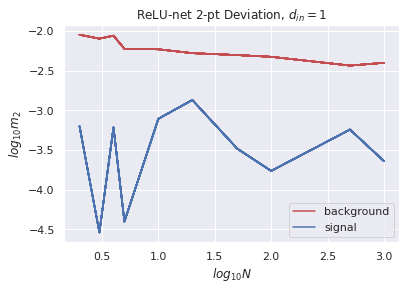

In [ ]:
std_df = pd.DataFrame(np.log10(m_n2.std(1)), columns=['background']*m_n2.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n2.mean(1))), columns=['signal']*m_n2.shape[-1])  
colors = ['r']*m_n2.shape[-1] + ['b']*m_n2.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_2$")
plt.title("ReLU-net 2-pt Deviation, $d_{in} = 1$")
plt.show() 

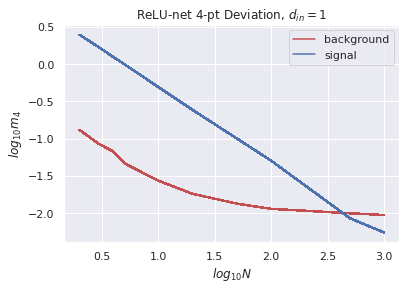

In [ ]:
std_df = pd.DataFrame(np.log10(m_n4.std(1)), columns=['background']*m_n4.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n4.mean(1))), columns=['signal']*m_n4.shape[-1])  
colors = ['r']*m_n4.shape[-1] + ['b']*m_n4.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_4$")
plt.title("ReLU-net 4-pt Deviation, $d_{in} = 1$")
plt.show() 

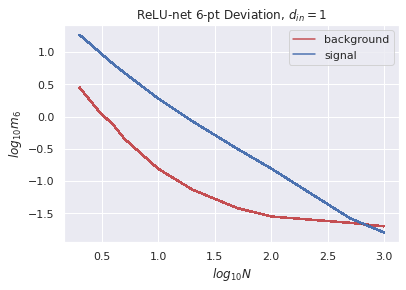

In [ ]:
std_df = pd.DataFrame(np.log10(m_n6.std(1)), columns=['background']*m_n6.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n6.mean(1))), columns=['signal']*m_n6.shape[-1])  
colors = ['r']*m_n6.shape[-1] + ['b']*m_n6.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_6$")
plt.title("ReLU-net 6-pt Deviation, $d_{in} = 1$")
plt.show()

## Erf-net

### Find all disinct combination of $x_i$

In [ ]:
comb2 = findsubsets(X_erf.reshape(-1), 2)
print(len(comb2))
comb4 = findsubsets(X_erf.reshape(-1), 4)
print(len(comb4))
comb6 = findsubsets(X_erf.reshape(-1), 6)
print(len(comb6))

### Calculate gaussian process 2, 4, 6-pt functions

In [ ]:
pt2_gp_erf = []
for c in comb2:
    pt2_gp_erf.append(G_gp2(c, K_erf))

pt2_gp_erf = np.array(pt2_gp_erf)

In [ ]:
pt4_gp_erf = []
for c in comb4:
    pt4_gp_erf.append(G_gp4(c, K_erf))

pt4_gp_erf = np.array(pt4_gp_erf)

In [ ]:
pt6_gp_erf = []
for c in comb6:
    pt6_gp_erf.append(G_gp6(c, K_erf))

pt6_gp_erf = np.array(pt6_gp_erf)

### Calculate the network output

In [ ]:
%%time
fx_exps = []

for N in Ns:

    print('Proceeding N =', N, '...')
    fx_exp = []
    for j in range(100):
        Y = []
        for i in range(100000):
            m = Erf(X_erf, 1, N)
            y = Dense(m, N, 1) 
            Y.append(y)
        Y = np.array(Y).reshape(100000, 6)
        fx_exp.append(Y)

    fx_exp = np.array(fx_exp)
    with open('/gdrive/MyDrive/NNGP/erf/fx_exp_'+str(N)+'.pickle', 'wb') as handle:
        pickle.dump(fx_exp, handle)
    fx_exps.append(fx_exp)

### Calculate and save $m_n$

In [ ]:
%%time
m_n2 = mn(X_erf, comb2, '/gdrive/MyDrive/NNGP/erf/', pt2_gp_erf)

with open('/gdrive/MyDrive/NNGP/erf_m_n2.pickle', 'wb') as handle:
    pickle.dump(m_n2, handle)

In [ ]:
%%time
m_n4 = mn(X_erf, comb4, '/gdrive/MyDrive/NNGP/erf/', pt4_gp_erf)

with open('/gdrive/MyDrive/NNGP/erf_m_n4.pickle', 'wb') as handle:
    pickle.dump(m_n4, handle)

In [ ]:
%%time
m_n6 = mn(X_erf, comb6, '/gdrive/MyDrive/NNGP/erf/', pt6_gp_erf)

with open('/gdrive/MyDrive/NNGP/erf_m_n6.pickle', 'wb') as handle:
    pickle.dump(m_n6, handle)

### Load $m_n$

In [ ]:
with open('/gdrive/MyDrive/NNGP/erf_m_n2.pickle', 'rb') as handle:
    m_n2 = pickle.load(handle)

with open('/gdrive/MyDrive/NNGP/erf_m_n4.pickle', 'rb') as handle:
    m_n4 = pickle.load(handle)

with open('/gdrive/MyDrive/NNGP/erf_m_n6.pickle', 'rb') as handle:
    m_n6 = pickle.load(handle)

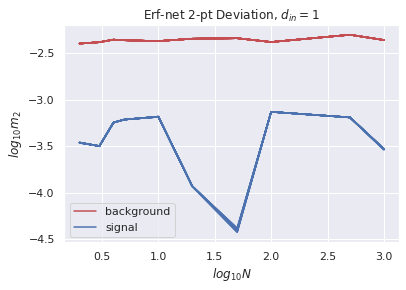

In [ ]:
std_df = pd.DataFrame(np.log10(m_n2.std(1)), columns=['background']*m_n2.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n2.mean(1))), columns=['signal']*m_n2.shape[-1])  
colors = ['r']*m_n2.shape[-1] + ['b']*m_n2.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_2$")
plt.title("Erf-net 2-pt Deviation, $d_{in} = 1$")
plt.show() 

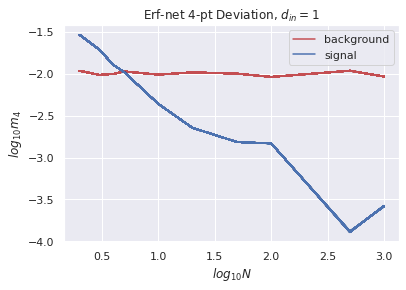

In [ ]:
std_df = pd.DataFrame(np.log10(m_n4.std(1)), columns=['background']*m_n4.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n4.mean(1))), columns=['signal']*m_n4.shape[-1])  
colors = ['r']*m_n4.shape[-1] + ['b']*m_n4.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_4$")
plt.title("Erf-net 4-pt Deviation, $d_{in} = 1$")
plt.show() 

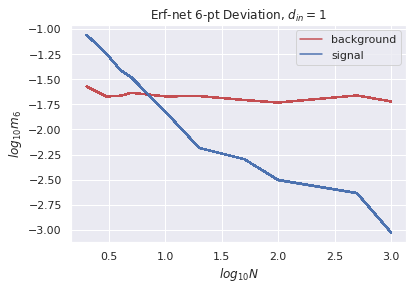

In [ ]:
std_df = pd.DataFrame(np.log10(m_n6.std(1)), columns=['background']*m_n6.shape[-1])
mean_df = pd.DataFrame(np.log10(np.abs(m_n6.mean(1))), columns=['signal']*m_n6.shape[-1])  
colors = ['r']*m_n6.shape[-1] + ['b']*m_n6.shape[-1]
concated_df = pd.concat([std_df, mean_df], axis=1)
concated_df.index = [np.log10(N) for N in Ns]
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}m_6$")
plt.title("Erf-net 6-pt Deviation, $d_{in} = 1$")
plt.show()